$$\sigma_x= \begin{bmatrix}0&1\\1&0\end{bmatrix} \sigma_y= \begin{bmatrix}0&-i\\i&0\end{bmatrix} \sigma_z= \begin{bmatrix}1&0\\0&-1\end{bmatrix} I= \begin{bmatrix}1&0\\0&1\end{bmatrix}$$

$$\sigma_x=|0\rangle\langle1| + |1\rangle\langle0|$$
$$\sigma_y=-i|0\rangle\langle1| + i|1\rangle\langle0|$$
$$\sigma_z=|0\rangle\langle0| - |1\rangle\langle1|$$
$$I=|0\rangle\langle0| + |1\rangle\langle1|$$

i) $|\psi\rangle=|0\rangle$

For $\sigma_x$
$$\langle0(|0\rangle\langle1|+|1\rangle\langle0|)0\rangle$$
$$\langle0|0\rangle\langle1|0\rangle+\langle0|1\rangle\langle0|0\rangle$$
$$(1)(0)+(0)(1) = 0$$

For $\sigma_y$
$$\langle0(-i|0\rangle\langle1|+i|1\rangle\langle0|)0\rangle$$
$$\langle0|0\rangle\langle1|0\rangle+\langle0|1\rangle\langle0|0\rangle$$
$$(1)(0)+(0)(1) = 0$$

For $\sigma_z$
$$\langle0(|0\rangle\langle1|+|1\rangle\langle0|)0\rangle$$
$$\langle0|0\rangle\langle1|0\rangle+\langle0|1\rangle\langle0|0\rangle$$
$$(1)(0)+(0)(1) = 0$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [52]:

# Define parameters
Ω_01 = 2 * np.pi * 1e6  # Rabi frequency, 1MHz
Ω_r = 2 * np.pi * 10e6  # 10 MHz in radians per second

γ_r = 1 / (5e-6)  # Decay rate from r state in Hz

δ1 = 2 * np.pi * 1e6   # 1 MHz detuning
#δ1 = 2 * np.pi * 100e3   # 1 MHz detuning

b_0r, b_1r, b_dr = 1/16, 1/16, 7/8  # Branching ratios

# Define basis states for the 4-level system
basis_states = [basis(4, i) for i in range(4)]
ket_0, ket_1, ket_r, ket_d = basis_states

In [66]:
# Decay rate = sqrt(branching ratios * decay rate of rydberg state) * lower level J ⊗ Rydberg state R
def LindbladDecayRate(decayRate, branchingRatio, state:Qobj, stateR:Qobj):
    return np.sqrt(decayRate * branchingRatio) * state * stateR.dag()
    

def simulator(H, rho, tlist):

    L_r0 = LindbladDecayRate(γ_r, b_0r,ket_0, ket_r)
    L_r1 = LindbladDecayRate(γ_r, b_1r,ket_1, ket_r)  
    L_rd = LindbladDecayRate(γ_r, b_dr,ket_d, ket_r) 

    # Collapse operators 
    c_ops = [L_r0, L_r1, L_rd]
    
    result = mesolve(H, rho, tlist, c_ops, [ket_0 * ket_0.dag(), ket_1 * ket_1.dag(), ket_r * ket_r.dag(), ket_d * ket_d.dag()],options=Options(store_states=True))
    
    return result

### 3.2.1 Exercise 1 - 0-1 Rabi Oscillations

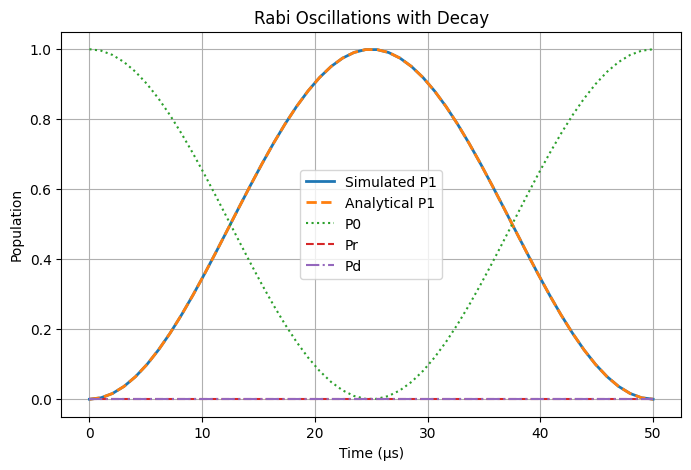

In [109]:
# Define the Hamiltonian
H = (Ω_01 / 2) * (ket_0 * ket_1.dag() + ket_1 * ket_0.dag())

rho = ket_0 * ket_0.dag()

tlist = np.linspace(0, 50e-6, 50)  # Up to 50 μs

result = simulator(H,rho,tlist)

# Extract populations
P0, P1, Pr, Pd = result.expect

# Compute analytical Rabi oscillation formula for P1
P1_analytical = np.sin(Ω_01 * tlist / 2) ** 2

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(tlist * 1e6, P1, label="Simulated P1", linewidth=2)
plt.plot(tlist * 1e6, P1_analytical, '--', label="Analytical P1", linewidth=2)
plt.plot(tlist * 1e6, P0, label="P0", linestyle="dotted")
plt.plot(tlist * 1e6, Pr, label="Pr", linestyle="dashed")
plt.plot(tlist * 1e6, Pd, label="Pd", linestyle="dashdot")

plt.xlabel("Time (μs)")
plt.ylabel("Population")
plt.title("Rabi Oscillations with Decay")
plt.legend()
plt.grid()
plt.show()

### Test Oscillations with Ωr > 0

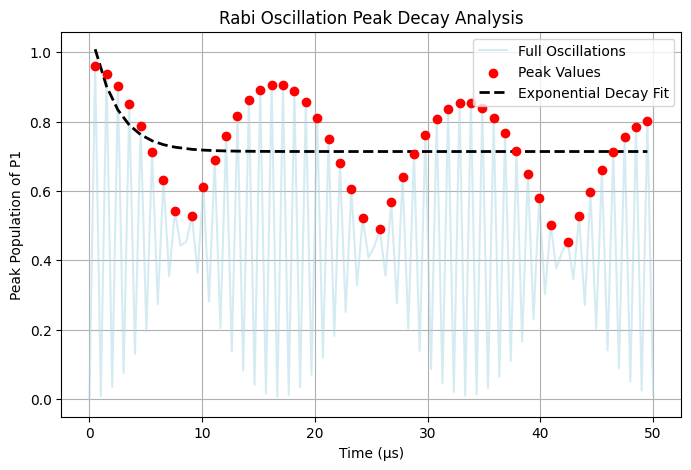

Fitted Decay Rate: γ = 0.446235 (1/μs)


In [ ]:
import scipy as sp

Ω = 2 * np.pi * 0.2e6

# Define the Hamiltonian|
H = (Ω_01 / 2) * (ket_0 * ket_1.dag() + ket_1 * ket_0.dag()) + (Ω / 2) * (ket_1 * ket_r.dag() + ket_r * ket_1.dag())

rho = ket_0 * ket_0.dag()

# Time evolution up to 50 μs in 100 steps
tlist = np.linspace(0, 50e-6, 100) 

result = simulator(H, rho, tlist)

# Extract populations
P0, P1, Pr, Pd = result.expect

# Compute analytical Rabi oscillation formula for P1
P1_analytical = np.sin(Ω_01 * tlist / 2) ** 2

# Extract P1 population
P1 = result.expect[1]

# Find peak values of P1
peak_indices, _ = sp.signal.find_peaks(P1)
t_peaks = tlist[peak_indices] * 1e6  # Convert to μs
P1_peaks = P1[peak_indices]

# Define an exponential decay function: P1_peak = A * exp(-γ * t) + C
def exp_decay(t, A, γ, C):
    return A * np.exp(-γ * t) + C

# Fit decay model to peak data
popt, _ = sp.optimize.curve_fit(exp_decay, t_peaks, P1_peaks, p0=[1, 0.1, 0])
P1_fitted = exp_decay(t_peaks, *popt)

# Plot data with fitted decay curve
plt.figure(figsize=(8, 5))

# Full oscillation dataset (faded for context)
plt.plot(tlist * 1e6, P1, color="lightblue", alpha=0.5, label="Full Oscillations")

# Peak values
plt.scatter(t_peaks, P1_peaks, color="red", label="Peak Values", zorder=3)

# Fitted decay trend
plt.plot(t_peaks, P1_fitted, color="black", linestyle="dashed", label="Exponential Decay Fit", linewidth=2)

plt.xlabel("Time (μs)")
plt.ylabel("Peak Population of P1")
plt.title("Rabi Oscillation Peak Decay Analysis")
plt.legend()
plt.grid()
plt.show()

# Print fitted decay rate
print(f"Fitted Decay Rate: γ = {popt[1]:.6f} (1/μs)")

### 3.2.2 Exercise 2 - Rydberg state lifetime

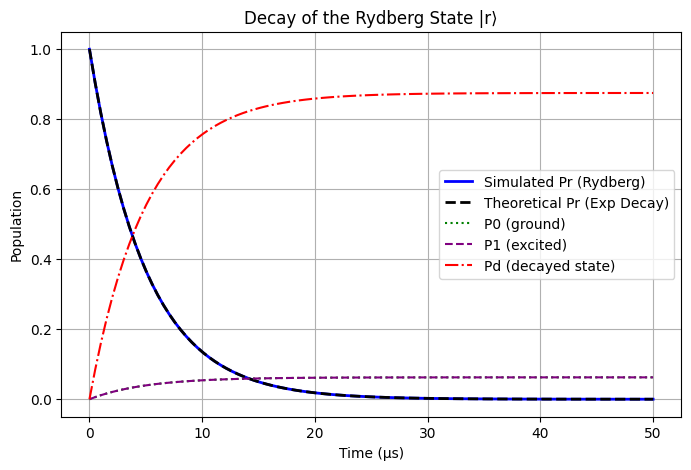

In [114]:
H = Qobj(np.zeros((4, 4)))

# Initial state: |r⟩ (Rydberg state)
rho = ket_r * ket_r.dag()

# Time evolution up to 50 μs in 100 steps
tlist = np.linspace(0, 50e-6, 100) 

# Solve the master equation
result =  simulator(H, rho, tlist)

# Extract populations
P0, P1, Pr, Pd = result.expect

# Theoretical exponential decay of |r⟩ state
Pr_theory = np.exp(-γ_r * tlist)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(tlist * 1e6, Pr, label="Simulated Pr (Rydberg)", linewidth=2, color="blue")
plt.plot(tlist * 1e6, Pr_theory, "--", label="Theoretical Pr (Exp Decay)", linewidth=2, color="black")
plt.plot(tlist * 1e6, P0, label="P0 (ground)", linestyle="dotted", color="green")
plt.plot(tlist * 1e6, P1, label="P1 (excited)", linestyle="dashed", color="purple")
plt.plot(tlist * 1e6, Pd, label="Pd (decayed state)", linestyle="dashdot", color="red")

plt.xlabel("Time (μs)")
plt.ylabel("Population")
plt.title("Decay of the Rydberg State |r⟩")
plt.legend()
plt.grid()
plt.show()

### 3.2.3 Exercise 3 - 0-r Rabi Oscillations

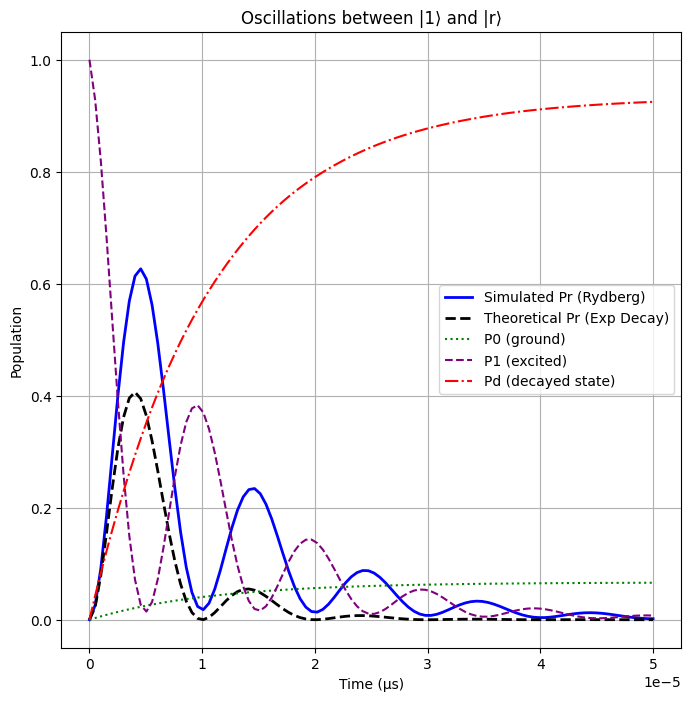

In [89]:
H = (Ω_r / 2) * (ket_1 * ket_r.dag() + ket_r * ket_1.dag())

# Initial state: |1⟩
rho = ket_1 * ket_1.dag()


tlist = np.linspace(0, 50e-6, 100)

result = simulator(H, rho, tlist)

# Extract populations
P0, P1, Pr, Pd = result.expect


# Compute theoretical damped Rabi oscillation for |r⟩
Pr_theory = np.exp(-γ_r * tlist) * np.sin(Ω_r * tlist / 2) ** 2



# Plot results
plt.figure(figsize=(8, 8))
plt.plot(tlist, Pr, label="Simulated Pr (Rydberg)", linewidth=2, color="blue")
plt.plot( tlist, Pr_theory, "--", label="Theoretical Pr (Exp Decay)", linewidth=2, color="black")
plt.plot(tlist, P0, label="P0 (ground)", linestyle="dotted", color="green")
plt.plot(tlist, P1, label="P1 (excited)", linestyle="dashed", color="purple")
plt.plot(tlist, Pd, label="Pd (decayed state)", linestyle="dashdot", color="red")

plt.xlabel("Time (μs)")
plt.ylabel("Population")
plt.title("Oscillations between |1⟩ and |r⟩")
plt.legend()
plt.grid()
plt.show()


### 3.2.4 Exercise 4 - 0-1 Detuned Rabi Oscillations

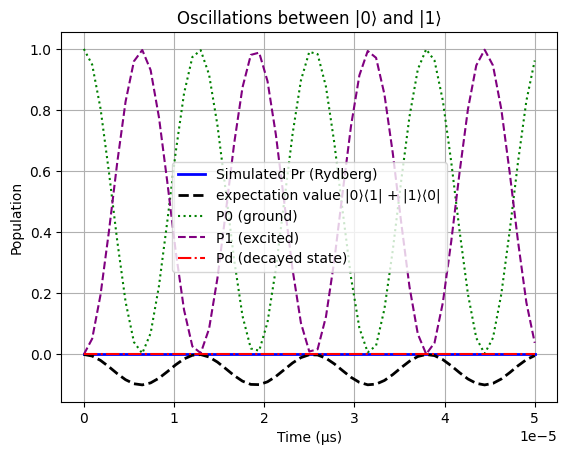

In [93]:
H = ((Ω_01 / 2) * (ket_0 * ket_1.dag() + ket_1 * ket_0.dag())) +((δ1/2)*ket_1*ket_1.dag())

# Initial state: |0⟩
rho = ket_0 * ket_0.dag()

tlist = np.linspace(0, 50e-6, 55)

result = simulator(H, rho, tlist)

# Extract populations
P0, P1, Pr, Pd = result.expect

#Expectation value |0⟩⟨1| + |1⟩⟨0|
coherence_op = ket_0 * ket_1.dag() + ket_1 * ket_0.dag()
coherence = [expect(coherence_op, state) for state in result.states]


# Plot results
plt.plot(figuresize=(8,8))
plt.plot(tlist, Pr, label="Simulated Pr (Rydberg)", linewidth=2, color="blue")
plt.plot(tlist, coherence, "--", label="expectation value |0⟩⟨1| + |1⟩⟨0|", linewidth=2, color="black")
plt.plot(tlist, P0, label="P0 (ground)", linestyle="dotted", color="green")
plt.plot(tlist, P1, label="P1 (excited)", linestyle="dashed", color="purple")
plt.plot(tlist, Pd, label="Pd (decayed state)", linestyle="dashdot", color="red")

plt.xlabel("Time (μs)")
plt.ylabel("Population")
plt.title("Oscillations between |0⟩ and |1⟩")
plt.legend()
plt.grid()

plt.show()


Set smaller detuning $(\delta_1(t)=100kHz)$ 

In [97]:
δ2 = 2 * np.pi * 100e3   # 100 kHz detuning

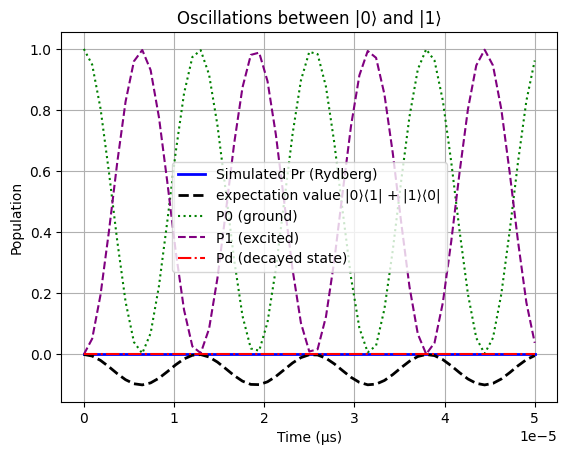

In [100]:
H = ((Ω_01 / 2) * (ket_0 * ket_1.dag() + ket_1 * ket_0.dag())) +((δ2/2)*ket_1*ket_1.dag())

# Initial state: |0⟩
rho = ket_0 * ket_0.dag()

tlist = np.linspace(0, 50e-6, 55)

result = simulator(H, rho, tlist)

# Extract populations
P0, P1, Pr, Pd = result.expect

#Expectation value |0⟩⟨1| + |1⟩⟨0|
coherence_op = ket_0 * ket_1.dag() + ket_1 * ket_0.dag()
coherence = [expect(coherence_op, state) for state in result.states]


# Plot results
plt.plot(figuresize=(8,8))
plt.plot(tlist, Pr, label="Simulated Pr (Rydberg)", linewidth=2, color="blue")
plt.plot(tlist, coherence, "--", label="expectation value |0⟩⟨1| + |1⟩⟨0|", linewidth=2, color="black")
plt.plot(tlist, P0, label="P0 (ground)", linestyle="dotted", color="green")
plt.plot(tlist, P1, label="P1 (excited)", linestyle="dashed", color="purple")
plt.plot(tlist, Pd, label="Pd (decayed state)", linestyle="dashdot", color="red")

plt.xlabel("Time (μs)")
plt.ylabel("Population")
plt.title("Oscillations between |0⟩ and |1⟩")
plt.legend()
plt.grid()

plt.show()